<a href="https://colab.research.google.com/github/chindimaga/Multiple-Object-Tracking/blob/master/MOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

fatal: destination path 'cocoapi' already exists and is not an empty directory.
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/mask.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.l

In [ ]:

!pip install filterpy

In [ ]:

%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be37608 version check against PyTorch's CUDA version


In [ ]:

# Getting the labels of dataset
!wget https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt

--2020-07-17 13:35:12--  https://raw.githubusercontent.com/nightrome/cocostuff/master/labels.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2287 (2.2K) [text/plain]
Saving to: ‘labels.txt.2’

labels.txt.2        100%[===================>]   2.23K  --.-KB/s    in 0s      

2020-07-17 13:35:12 (35.0 MB/s) - ‘labels.txt.2’ saved [2287/2287]



In [ ]:
# Storing the labels in a dictionary
filename = '/content/labels.txt'
labels_dict = {} 
# creating dictionary 
with open(filename) as fh:
  for line in fh: 
    command, description = line.split(':',1) 
    labels_dict[command] = description.strip()
  
labels_dict

{'0': 'unlabeled',
 '1': 'person',
 '10': 'traffic light',
 '100': 'cardboard',
 '101': 'carpet',
 '102': 'ceiling-other',
 '103': 'ceiling-tile',
 '104': 'cloth',
 '105': 'clothes',
 '106': 'clouds',
 '107': 'counter',
 '108': 'cupboard',
 '109': 'curtain',
 '11': 'fire hydrant',
 '110': 'desk-stuff',
 '111': 'dirt',
 '112': 'door-stuff',
 '113': 'fence',
 '114': 'floor-marble',
 '115': 'floor-other',
 '116': 'floor-stone',
 '117': 'floor-tile',
 '118': 'floor-wood',
 '119': 'flower',
 '12': 'street sign',
 '120': 'fog',
 '121': 'food-other',
 '122': 'fruit',
 '123': 'furniture-other',
 '124': 'grass',
 '125': 'gravel',
 '126': 'ground-other',
 '127': 'hill',
 '128': 'house',
 '129': 'leaves',
 '13': 'stop sign',
 '130': 'light',
 '131': 'mat',
 '132': 'metal',
 '133': 'mirror-stuff',
 '134': 'moss',
 '135': 'mountain',
 '136': 'mud',
 '137': 'napkin',
 '138': 'net',
 '139': 'paper',
 '14': 'parking meter',
 '140': 'pavement',
 '141': 'pillow',
 '142': 'plant-other',
 '143': 'plastic'

In [ ]:
rm /content/img_data -r

In [ ]:
import os
from sklearn.utils.linear_assignment_ import linear_assignment
try: 
      
    # creating a folder named data 
    if not os.path.exists('/content/img_data'): 
        os.makedirs('/content/img_data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
import cv2
import math
#the path of the video input
PATH='/content/drive/My Drive/Datasets/Cricket/Mindless peoples on the road. !!! Incidents !!! CCTV Captured..mp4'
#video input
cap = cv2.VideoCapture(PATH)
#fps of the video
fps = cap.get(cv2.CAP_PROP_FPS)

# Used as counter variable 
count = 0

while(cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
      break
    # Saves the frames with frame-count 
    name = "/content/img_data/frame" + str(count).zfill(6)+".jpg"
    cv2.imwrite(name, frame) 

    count += 1
cap.release()    

In [ ]:
IMG_FOL = '/content/img_data'
#directory of folder in which folder is contained

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import utils
import transforms as T
# custom dataset loader
class LoadDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(root)))
        # self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root,  self.imgs[idx])
        # mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        target = {}
        if self.transforms is not None:
          img, target = self.transforms(img, target)

        return img, target


    def __len__(self):
        return len(self.imgs)

In [ ]:
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# dataset loaded
dataset = LoadDataset(IMG_FOL,get_transform(train=False))

In [ ]:
import torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device);

In [ ]:
img, _ = dataset[0]

In [ ]:
len(dataset)

2978

In [ ]:
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [ ]:
prediction

[{'boxes': tensor([[ 884.5861,   44.2485, 1040.2173,  113.4136],
          [ 235.7930,  117.5663,  348.5062,  187.0580],
          [ 270.2581,   61.6553,  456.4799,  147.5663],
          [ 217.8906,  561.1495,  253.4849,  579.6206],
          [ 162.4038,  572.7141,  704.6562,  714.0022],
          [ 269.0349,  105.8182,  305.6442,  178.3019],
          [ 652.3951,  560.2612,  897.2650,  720.0000],
          [ 711.9790,   38.9252,  754.4680,   87.7060],
          [ 286.1649,   41.0921,  309.7649,   64.2518],
          [ 827.9576,   10.4654,  987.8882,   73.9977],
          [ 150.2379,  565.4192,  734.0441,  717.6266],
          [  29.9581,   72.0984, 1257.1244,  720.0000],
          [ 397.6650,   69.0745,  458.3517,  135.9095],
          [ 104.2833,  526.6537, 1233.3550,  717.0516],
          [1034.9363,  173.7639, 1268.7816,  261.2079],
          [ 269.5037,  110.9783,  336.4307,  176.8204],
          [ 252.2128,  109.8543,  312.5049,  182.2948],
          [ 269.6986,  108.7430,  292.1

In [ ]:
test_image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
test_img = np.array(test_image) 
test_img = test_img[:, :, ::-1].copy() 


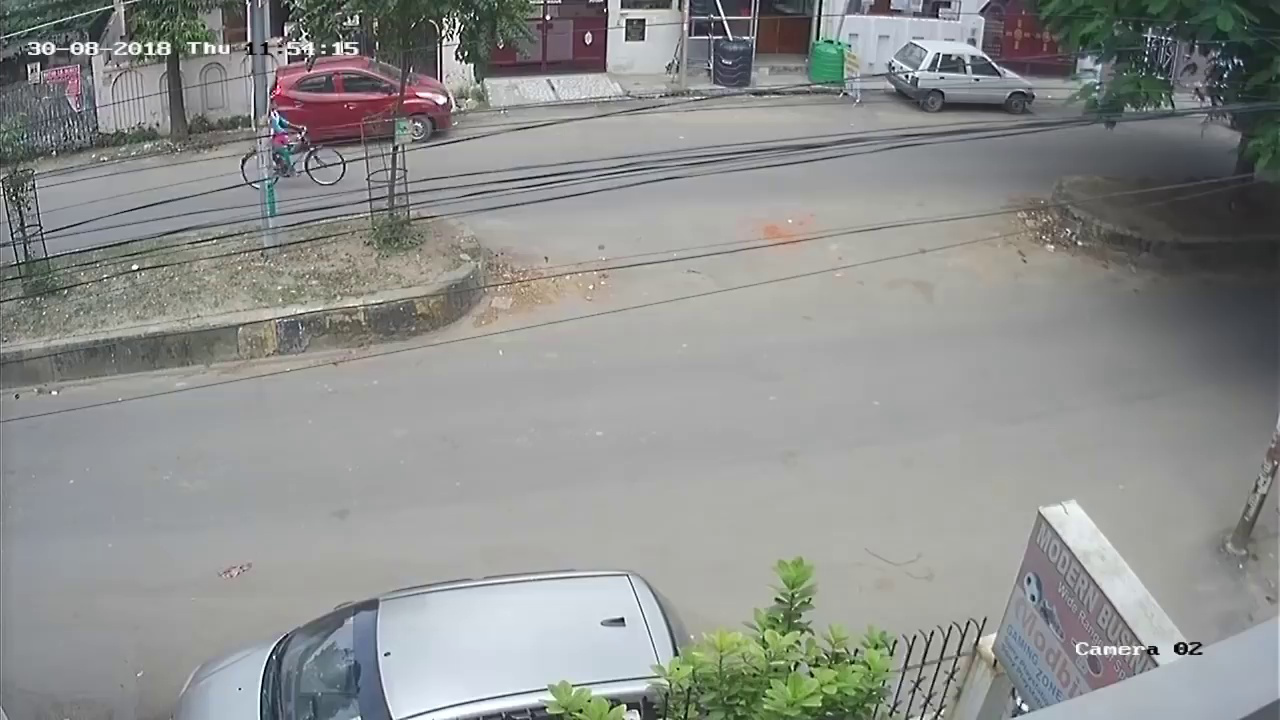

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(test_img)

In [ ]:
h , w  = test_img.shape[:2]
print(h,w)

720 1280


In [ ]:


def box_iou2(a, b):
    '''
    Helper funciton to calculate the ratio between intersection and the union of
    two boxes a and b
    a[0], a[1], a[2], a[3] <-> left, up, right, bottom
    '''
    
    w_intsec = np.maximum (0, (np.minimum(a[2], b[2]) - np.maximum(a[0], b[0])))
    h_intsec = np.maximum (0, (np.minimum(a[3], b[3]) - np.maximum(a[1], b[1])))
    s_intsec = w_intsec * h_intsec
    s_a = (a[2] - a[0])*(a[3] - a[1])
    s_b = (b[2] - b[0])*(b[3] - b[1])
  
    return float(s_intsec)/(s_a + s_b -s_intsec)

In [ ]:
def assign_detections_to_trackers(trackers, detections, iou_thrd = 0.3):
    '''
    From current list of trackers and new detections, output matched detections,
    unmatchted trackers, unmatched detections.
    '''    
    
    IOU_mat= np.zeros((len(trackers),len(detections)),dtype=np.float32)
    for t,trk in enumerate(trackers):
        #trk = convert_to_cv2bbox(trk) 
        for d,det in enumerate(detections):
         #   det = convert_to_cv2bbox(det)
            IOU_mat[t,d] = box_iou2(trk,det) 
    
    # Produces matches       
    # Solve the maximizing the sum of IOU assignment problem using the
    # Hungarian algorithm (also known as Munkres algorithm)
    
    matched_idx = linear_assignment(-IOU_mat)        

    unmatched_trackers, unmatched_detections = [], []
    for t,trk in enumerate(trackers):
        if(t not in matched_idx[:,0]):
            unmatched_trackers.append(t)

    for d, det in enumerate(detections):
        if(d not in matched_idx[:,1]):
            unmatched_detections.append(d)

    matches = []
   
    # For creating trackers we consider any detection with an 
    # overlap less than iou_thrd to signifiy the existence of 
    # an untracked object
    
    for m in matched_idx:
        if(IOU_mat[m[0],m[1]]<iou_thrd):
            unmatched_trackers.append(m[0])
            unmatched_detections.append(m[1])
        else:
            matches.append(m.reshape(1,2))
    
    if(len(matches)==0):
        matches = np.empty((0,2),dtype=int)
    else:
        matches = np.concatenate(matches,axis=0)
    
    return matches, np.array(unmatched_detections), np.array(unmatched_trackers)       


In [ ]:
import numpy as np
from numpy import dot
from scipy.linalg import inv, block_diag



class Tracker(): # class for Kalman Filter-based tracker
    def __init__(self):
        # Initialize parametes for tracker (history)
        self.id = 0  # tracker's id 
        self.box = [] # list to store the coordinates for a bounding box 
        self.hits = 0 # number of detection matches
        self.no_losses = 0 # number of unmatched tracks (track loss)
        
        # Initialize parameters for Kalman Filtering
        # The state is the (x, y) coordinates of the detection box
        # state: [up, up_dot, left, left_dot, down, down_dot, right, right_dot]
        # or[up, up_dot, left, left_dot, height, height_dot, width, width_dot]
        self.x_state=[] 
        self.dt = 1.   # time interval
        
        # Process matrix, assuming constant velocity model
        self.F = np.array([[1, self.dt, 0,  0,  0,  0,  0, 0],
                           [0, 1,  0,  0,  0,  0,  0, 0],
                           [0, 0,  1,  self.dt, 0,  0,  0, 0],
                           [0, 0,  0,  1,  0,  0,  0, 0],
                           [0, 0,  0,  0,  1,  self.dt, 0, 0],
                           [0, 0,  0,  0,  0,  1,  0, 0],
                           [0, 0,  0,  0,  0,  0,  1, self.dt],
                           [0, 0,  0,  0,  0,  0,  0,  1]])
        
        # Measurement matrix, assuming we can only measure the coordinates
        
        self.H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0, 0, 0, 0],
                           [0, 0, 0, 0, 1, 0, 0, 0], 
                           [0, 0, 0, 0, 0, 0, 1, 0]])
        
        
        # Initialize the state covariance
        self.L = 10.0
        self.P = np.diag(self.L*np.ones(8))
        
        
        # Initialize the process covariance
        self.Q_comp_mat = np.array([[self.dt**4/4., self.dt**3/2.],
                                    [self.dt**3/2., self.dt**2]])
        self.Q = block_diag(self.Q_comp_mat, self.Q_comp_mat, 
                            self.Q_comp_mat, self.Q_comp_mat)
        
        # Initialize the measurement covariance
        self.R_scaler = 1.0
        self.R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(self.R_diag_array)
        
        
    def update_R(self):   
        R_diag_array = self.R_scaler * np.array([self.L, self.L, self.L, self.L])
        self.R = np.diag(R_diag_array)
        
        
        
        
    def kalman_filter(self, z): 
        '''
        Implement the Kalman Filter, including the predict and the update stages,
        with the measurement z
        '''
        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q

        #Update
        S = dot(self.H, self.P).dot(self.H.T) + self.R
        K = dot(self.P, self.H.T).dot(inv(S)) # Kalman gain
        y = z - dot(self.H, x) # residual
        x += dot(K, y)
        self.P = self.P - dot(K, self.H).dot(self.P)
        self.x_state = x.astype(int) # convert to integer coordinates 
                                     #(pixel values)
        
    def predict_only(self):  
        '''
        Implment only the predict stage. This is used for unmatched detections and 
        unmatched tracks
        '''
        x = self.x_state
        # Predict
        x = dot(self.F, x)
        self.P = dot(self.F, self.P).dot(self.F.T) + self.Q
        self.x_state = x.astype(int)

In [ ]:
def pipeline(z_box):
    '''
    Pipeline function for detection and tracking
    '''
    global frame_count
    global tracker_list
    global max_age
    global min_hits
    global track_id_list
    global debug
    global model
    
    frame_count+=1
    
    
    if debug:
       print('Frame:', frame_count)
       
    x_box =[]
    
    if len(tracker_list) > 0:
        for trk in tracker_list:
            x_box.append(trk.box)
    
    
    matched, unmatched_dets, unmatched_trks \
    = assign_detections_to_trackers(x_box, z_box, iou_thrd = 0.25)  
    if debug:
         print('Detection: ', z_box)
         print('x_box: ', x_box)
         print('matched:', matched)
         print('unmatched_det:', unmatched_dets)
         print('unmatched_trks:', unmatched_trks)
    
         
    # Deal with matched detections     
    if matched.size >0:
        for trk_idx, det_idx in matched:
            z = z_box[det_idx]
            z = np.expand_dims(z, axis=0).T
            tmp_trk= tracker_list[trk_idx]
            tmp_trk.kalman_filter(z)
            xx = tmp_trk.x_state.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            x_box[trk_idx] = xx
            tmp_trk.box =xx
            tmp_trk.hits += 1
            tmp_trk.no_losses = 0
    
    # Deal with unmatched detections      
    if len(unmatched_dets)>0:
        for idx in unmatched_dets:
            z = z_box[idx]
            z = np.expand_dims(z, axis=0).T
            tmp_trk = Tracker() # Create a new tracker
            x = np.array([[z[0], 0, z[1], 0, z[2], 0, z[3], 0]]).T
            tmp_trk.x_state = x
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box = xx
            tmp_trk.id = track_id_list.popleft() # assign an ID for the tracker
            tracker_list.append(tmp_trk)
            x_box.append(xx)
    
    # Deal with unmatched tracks       
    if len(unmatched_trks)>0:
        for trk_idx in unmatched_trks:
            tmp_trk = tracker_list[trk_idx]
            tmp_trk.no_losses += 1
            tmp_trk.predict_only()
            xx = tmp_trk.x_state
            xx = xx.T[0].tolist()
            xx =[xx[0], xx[2], xx[4], xx[6]]
            tmp_trk.box =xx
            x_box[trk_idx] = xx
                   
       
    # The list of tracks to be annotated  
    good_tracker_list =[]
    plot_box = []
    plot_id = []
    for trk in tracker_list:
        if ((trk.hits >= min_hits) and (trk.no_losses <=max_age)):
             good_tracker_list.append(trk)
             x_cv2 = trk.box
             if debug:
                 print('updated box: ', x_cv2)
                 print()
             plot_box.append(x_cv2)
             plot_id.append( trk.id);
    
    tracker_list = [x for x in tracker_list if x.no_losses<=max_age]
    
    if debug:
       print('Ending tracker_list: ',len(tracker_list))
       print('Ending good tracker_list: ',len(good_tracker_list))
    
       
    return plot_id, plot_box

In [ ]:
from collections import deque
frame_count = 0 # frame counter

max_age = int(fps)  # no.of consecutive unmatched detection before 
             # a track is deleted

min_hits =2  # no. of consecutive matches needed to establish a track

tracker_list =[] # list for trackers
# list for track ID
track_id_list= deque([str(i) for i in range(1000)])

debug = False

In [ ]:
import cv2
model.eval()
'''using cv2.VideoWriter to get the output as a video'''
h , w  = test_img.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("/content/drive/My Drive/Downloads/attemptm.avi", fourcc, fps ,(w , h ), True)

'''loading all the input images one by one and performing operations'''

for i in range(len(dataset)):
  img, _ = dataset[i]
  with torch.no_grad():
    prediction = model([img.to(device)])
  test_image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  scores = prediction[0]['scores'].cpu().numpy()
  labels = prediction[0]['labels'].cpu().numpy()
  BoundBox = prediction[0]['boxes'].cpu().numpy()
  test_img = np.array(test_image) 
  test_img = test_img[:, :, ::-1].copy()
  kal_box=[]
  for i,lab in enumerate(labels):
    if scores[i] < 0.7:
      break
    if lab==1:
      kal_box.append(BoundBox[i])
    # print(kal_box)  


  ids, final = pipeline(kal_box)
  for i in range(len (final)):
    # applying bounding box only if prediction score is above .5
      x1, y1, x2, y2 = final[i]
      cv2.rectangle(test_img,(x1,y1),(x2,y2),(255,0,0),3)
      cv2.putText(test_img, str(ids[i]), (x1, y1), cv2.FONT_HERSHEY_COMPLEX,1, (0, 255, 0), 1)
      '''final output'''
  out.write(test_img)
print('Its done!!')
out.release()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Its done!!


In [ ]:
#############################################################################3

In [ ]:

# !pip install motmetrics

In [ ]:
# import motmetrics as mm
# import numpy as np

# # Create an accumulator that will be updated during each frame
# acc = mm.MOTAccumulator(auto_id=True)

# # Call update once for per frame. For now, assume distances between
# # frame objects / hypotheses are given.
# o = np.array([
#     [1., 2],
#     [2., 2],
#     [3., 2],
# ])

# # Hypothesis related points
# h = np.array([
#     [0., 0],
#     [1., 1],
# ])

# C = mm.distances.norm2squared_matrix(o, h, max_d2=5.)
# acc.update(
#     [1, 2, 3],                     # Ground truth objects in this frame
#     [1, 2],                  # Detector hypotheses in this frame
#     C
# )

In [ ]:
# print(acc.mot_events)

In [ ]:
# frameid = acc.update(
#     [1, 2],
#     [1],
#     [
#         [0.2],
#         [0.4]
#     ]
# )
# frameid = acc.update(
#     [1, 2],
#     [1, 3],
#     [
#         [0.6, 0.2],
#         [0.1, 0.6]
#     ]
# )

In [ ]:
# mh = mm.metrics.create()
# summary = mh.compute_many(
#     [acc, acc.events.loc[0:1]],
#     metrics=mm.metrics.motchallenge_metrics,
#     names=['full', 'part'])

# strsummary = mm.io.render_summary(
#     summary,
#     formatters=mh.formatters,
#     namemap=mm.io.motchallenge_metric_names
# )
# print(strsummary)